# Importations


In [21]:
import random as rd
import pandas as pd
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
sns.reset_defaults()
sns.set(palette = 'colorblind', style = 'white')

## 1) Preprocess the data

### 1) a. Set the random seed to 0.

In [23]:
rd.seed(0)

### 1) b. Load the data. Print the mean, and standard deviation of every covariate. Is the data centered? Normalized? Standardized?

In [ ]:
df = pd.read_csv('/meatspec.csv')
df.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,fat
0,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,2.98145,2.96072,2.94013,2.91978,2.89966,2.87964,2.85960,2.83940,2.81920,22.5
1,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,2.87661,...,3.29186,3.27921,3.26655,3.25369,3.24045,3.22659,3.21181,3.19600,3.17942,40.1
2,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,2.68951,2.67009,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816,8.4


In [ ]:
df.describe().iloc[1:3, :]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,fat
mean,2.808561,2.811137,2.813727,2.816363,2.819098,2.821983,2.825064,2.828375,2.831943,2.835813,...,3.178262,3.158254,3.138534,3.119104,3.099971,3.08107,3.062290,3.043548,3.024895,18.142326
std,0.410793,0.413352,0.415906,0.418465,0.421040,0.423635,0.426245,0.428866,0.431510,0.434195,...,0.541957,0.541776,0.541519,0.541135,0.540563,0.53973,0.538586,0.537108,0.535354,12.740297


The mean values of the covariates are different from 0, so the data is not centered. Therefore, the data is not standardized either. Finally, the values are not between 0 and 1, so the data is not normalized.

### 1) c. Separate the data in train and test sets: save one fourth of the data as testing (you can use train_test_split from sklearn.model_selection) and standardize both the training and testing sets using the fit_transform and transform functions in sklearn.preprocessing.StandardScaler.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as scaler

In [25]:
# Assign values to the X and y variables:
X = df.drop('fat', axis = 1)
Y = df['fat']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25 , random_state = 0)

X_train = pd.DataFrame(scaler().fit_transform(X_train))
Y_train = pd.DataFrame(scaler().fit_transform(np.array(Y_train).reshape(-1,1)))
X_test = pd.DataFrame(scaler().fit_transform(X_test))
Y_test = pd.DataFrame(scaler().fit_transform(np.array(Y_test).reshape(-1,1)))

### 1) d. Fit a regular OLS, do we need to fit the intercept?

In [ ]:
import statsmodels.api as sm

In [ ]:
print(X_train.mean())

0    -4.413309e-17
1     9.654113e-18
2     1.461909e-16
3    -4.978764e-16
4    -9.695488e-16
          ...     
95    6.237247e-16
96   -9.481718e-17
97   -3.203097e-16
98    1.565346e-16
99   -6.075196e-16
Length: 100, dtype: float64


The means of the covariates are not null but really close to 0. Thus, we can consider that the variables are centered and we don't need to fit the intercept.

In [27]:
model = sm.OLS(Y_train, X_train)
results_OLS = model.fit()

print(results_OLS.summary())

                                 OLS Regression Results                                
Dep. Variable:                      0   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              144.2
Date:                Fri, 17 Feb 2023   Prob (F-statistic):                    2.56e-51
Time:                        11:08:34   Log-Likelihood:                          211.89
No. Observations:                 161   AIC:                                     -223.8
Df Residuals:                      61   BIC:                                      84.37
Df Model:                         100                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

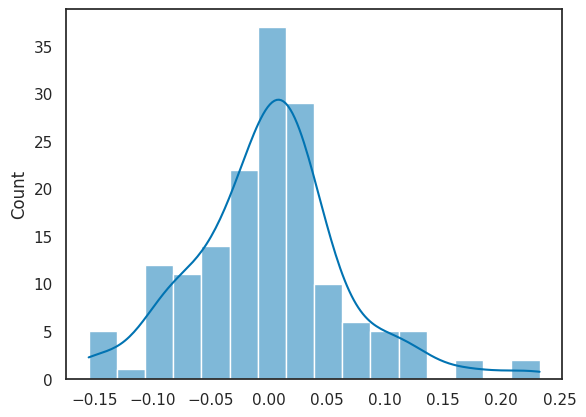

In [29]:
u = results_OLS.resid
plt.show()
sns.histplot(data = u, kde = True, palette = 'hot', 
             legend = "Residuals of the OLS regression of fat")

The residuals for this regression appear to be distributed according to a centered normal distribution. Therefore, the estimator can be assumed to be unbiased and the OLS regression fitted. 

### 1) e. Create a dataFrame df_coef and store the R2 coefficients of the estimated model. This data frame will be used along the TP to store and compare R2 coefficients of other variants of the OLS problem.


In [32]:
R0 = np.corrcoef(Y_test[0], X_test@results_OLS.params)[0,1]
df_coef = pd.DataFrame([R0], columns=['R2'])
df_coef

,R2
0,0.972177


# Variable selection
## 2) Program the method of the forward variable selection. You can use the test statistics of the test for nullity (as seen during the course). Do not define the stop criterion for the method, i.e. add a variables at each time until all the variables are used. Store the order of the variable selection and the associated p-value for each of them.

In [31]:
def FVS(columns):

    y = Y_train
    #set of covariates to consider in the regression of 'fat'
    #at first, it is empty
    covariates = np.zeros(np.shape(y))
    names = []
    #set of p values 
    p_values = []
    

    while len(columns)>0:
        t_max = 0 
        #at each turn, we make all the regressions for the variables in columns
        #we search for max(abs(t_value)) and store the p-value associated 
        for i in columns:
            X = np.column_stack((covariates, X_train[i-1]))
            result = sm.OLS(y, X).fit()
            value_t = result.tvalues[-1]
            
            if abs(value_t) > t_max : 
                t_max = abs(value_t)
                p_min = result.pvalues[-1]
                new_covariate = i
    
        #at the end, we have the covariate that maximizes abs(t-value)
        #we remove it from columns and add it to the set covariates
        #we also store its p-value                                   
        names.append(new_covariate)  
        columns.remove(new_covariate) 
        covariates = np.column_stack((covariates, X_train[new_covariate-1]))
        p_values.append(p_min)         

    
    return names, p_values

In [33]:
names, values = FVS([i for i in range(1, 101)])

print(np.array(names))
print('\n')
print(np.array(values))

[ 41  20  48  22   1  57  71 100  47  49  99  90  69  59  74  56  50  88
  97  65  79  98  64  73  70  18   2  21  46  40  35  45  89  61   3  36
  86  42  33  23   5   8  54  87  55  53  85  12  16   7  13  25  24  29
  60  19  63  34  28  30  39  80   4   6  10  78  81  43  27  37  44  51
  58  14  84  52  76  82  15  11  26  91  95  68  75  77   9  66  67  31
  32  92  94  93  72  38  96  83  62  17]


[8.22578871e-15 9.13215139e-61 1.69048149e-26 2.92358037e-08
 2.39517757e-03 1.51937702e-02 1.55341216e-02 1.00614756e-02
 5.39760119e-05 1.23998452e-02 5.95052907e-03 9.20783823e-03
 8.67286096e-03 1.28620792e-03 2.03823031e-02 1.02853992e-02
 7.16062760e-03 1.19981637e-03 1.00257726e-02 7.85285048e-02
 9.76316637e-02 4.95422155e-02 1.26947259e-01 8.28868621e-02
 1.81758398e-02 4.62387893e-02 3.29854486e-03 4.47156808e-03
 1.21150640e-01 1.08230499e-02 1.83666667e-04 2.87325680e-04
 5.46015174e-03 1.91217169e-02 4.20916196e-02 5.53218368e-02
 3.19239954e-02 1.57641477e-02 4.19592630e

## 3) Run OLS on the variables with a p-value smaller than 0.05. 

### 3) a. Apply the OLS of the sklearn library.

In [34]:
columns = [] 
for k,i in enumerate(values):
    if i<0.05:
        columns.append(names[k])
    
X1 = np.column_stack((X_train[k-1] for k in columns))

<ipython-input-34-03879f6b5214>:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X1 = np.column_stack((X_train[k-1] for k in columns))


In [ ]:
import sklearn.linear_model as lin

In [35]:
#we stock len(columns) for the next question
n = len(columns)

linear = lin.LinearRegression(fit_intercept = False)
results_fvs = linear.fit(X1, Y_train)

### Store the R2 coefficient in df_coef.

In [36]:
X1_test = pd.DataFrame(np.column_stack((X_test[i-1] for i in columns)))
df_coef.loc[1] = [np.corrcoef(Y_test[0], (X1_test@(results_fvs.coef_.T))[0])[0,1]]
df_coef

<ipython-input-36-39cdce4db370>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X1_test = pd.DataFrame(np.column_stack((X_test[i-1] for i in columns)))


,R2
0,0.972177
1,0.966542


With this selection, we obtain a less better R2. 

## 4) Using SequentialFeatureSelector on a linear regression estimator select (with forward selection), select the same number of variables as in the previous question. Elaborate on why the 2 algorithms do not return the same variables and store the R2 onto the corresponding dataFrame.

In [37]:
from sklearn.feature_selection import SequentialFeatureSelector as SFS

In [38]:
sfs = SFS(lin.LinearRegression(), n_features_to_select = n)
sfs = sfs.fit(X_train, Y_train)

In [40]:
X2 = np.column_stack((X_train[int(i[1:])] for i in sfs.get_feature_names_out())) 
results_SFS = sm.OLS(Y_train, X2).fit()
print(results_SFS.summary())

                                 OLS Regression Results                                
Dep. Variable:                      0   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                              297.2
Date:                Fri, 17 Feb 2023   Prob (F-statistic):                   3.16e-105
Time:                        11:11:14   Log-Likelihood:                          127.82
No. Observations:                 161   AIC:                                     -185.6
Df Residuals:                     126   BIC:                                     -77.78
Df Model:                          35                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<ipython-input-40-6de7dace5cec>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X2 = np.column_stack((X_train[int(i[1:])] for i in sfs.get_feature_names_out()))


In [41]:
bis = sorted(columns)
print(bis)
print('\n')
print([int(i[1:]) + 1 for i in sfs.get_feature_names_out()])

[1, 2, 3, 6, 18, 20, 21, 22, 33, 35, 40, 41, 42, 45, 47, 48, 49, 50, 53, 56, 57, 59, 61, 69, 70, 71, 74, 86, 88, 89, 90, 97, 98, 99, 100]


[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 15, 18, 19, 20, 21, 22, 23, 24, 35, 40, 41, 42, 45, 46, 47, 48, 49, 50, 58, 75, 88, 91, 98, 100]


Estimators have a score method providing a default evaluation criterion for the problem they are designed to solve. It seems that the LinearRegression's score frm sklearn is R2, so the criteria of selection is the coefficient of correlation. This can explain the fact that the covariates selected are not the same. 

In [43]:
X2_test = pd.DataFrame(np.column_stack((X_test[int(i[1:])] for i in sfs.get_feature_names_out())))
df_coef.loc[2] = [np.corrcoef(Y_test[0], X2_test@np.array(results_SFS.params))[0,1]]
df_coef

<ipython-input-43-2f0f9cfee928>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X2_test = pd.DataFrame(np.column_stack((X_test[int(i[1:])] for i in sfs.get_feature_names_out())))


,R2
0,0.972177
1,0.966542
2,0.973532


The correlation coefficient is slightly better than the one of the first OLS. It makes sense since the previous method focuses on improving R2. 

# Ridge

## 5) Code your own ridge estimator using expression derived in class. Test it for a penalty parameter α spaced evenly on a log scale 10e-9 to 10e2.



### 5) a. Plot how the values of the coefficients change with α.

In [44]:
def ridge(a, X, Y):
    n = X.shape[0]
    p = X.shape[1]
    return np.linalg.inv(X.T@X + n*a*np.identity(p))@X.T@Y

In [45]:
A = np.logspace(-8, 3)

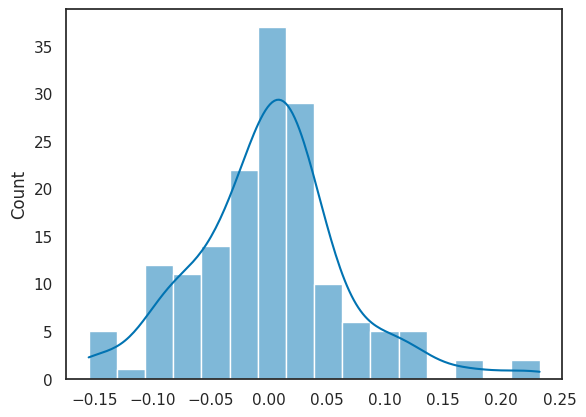

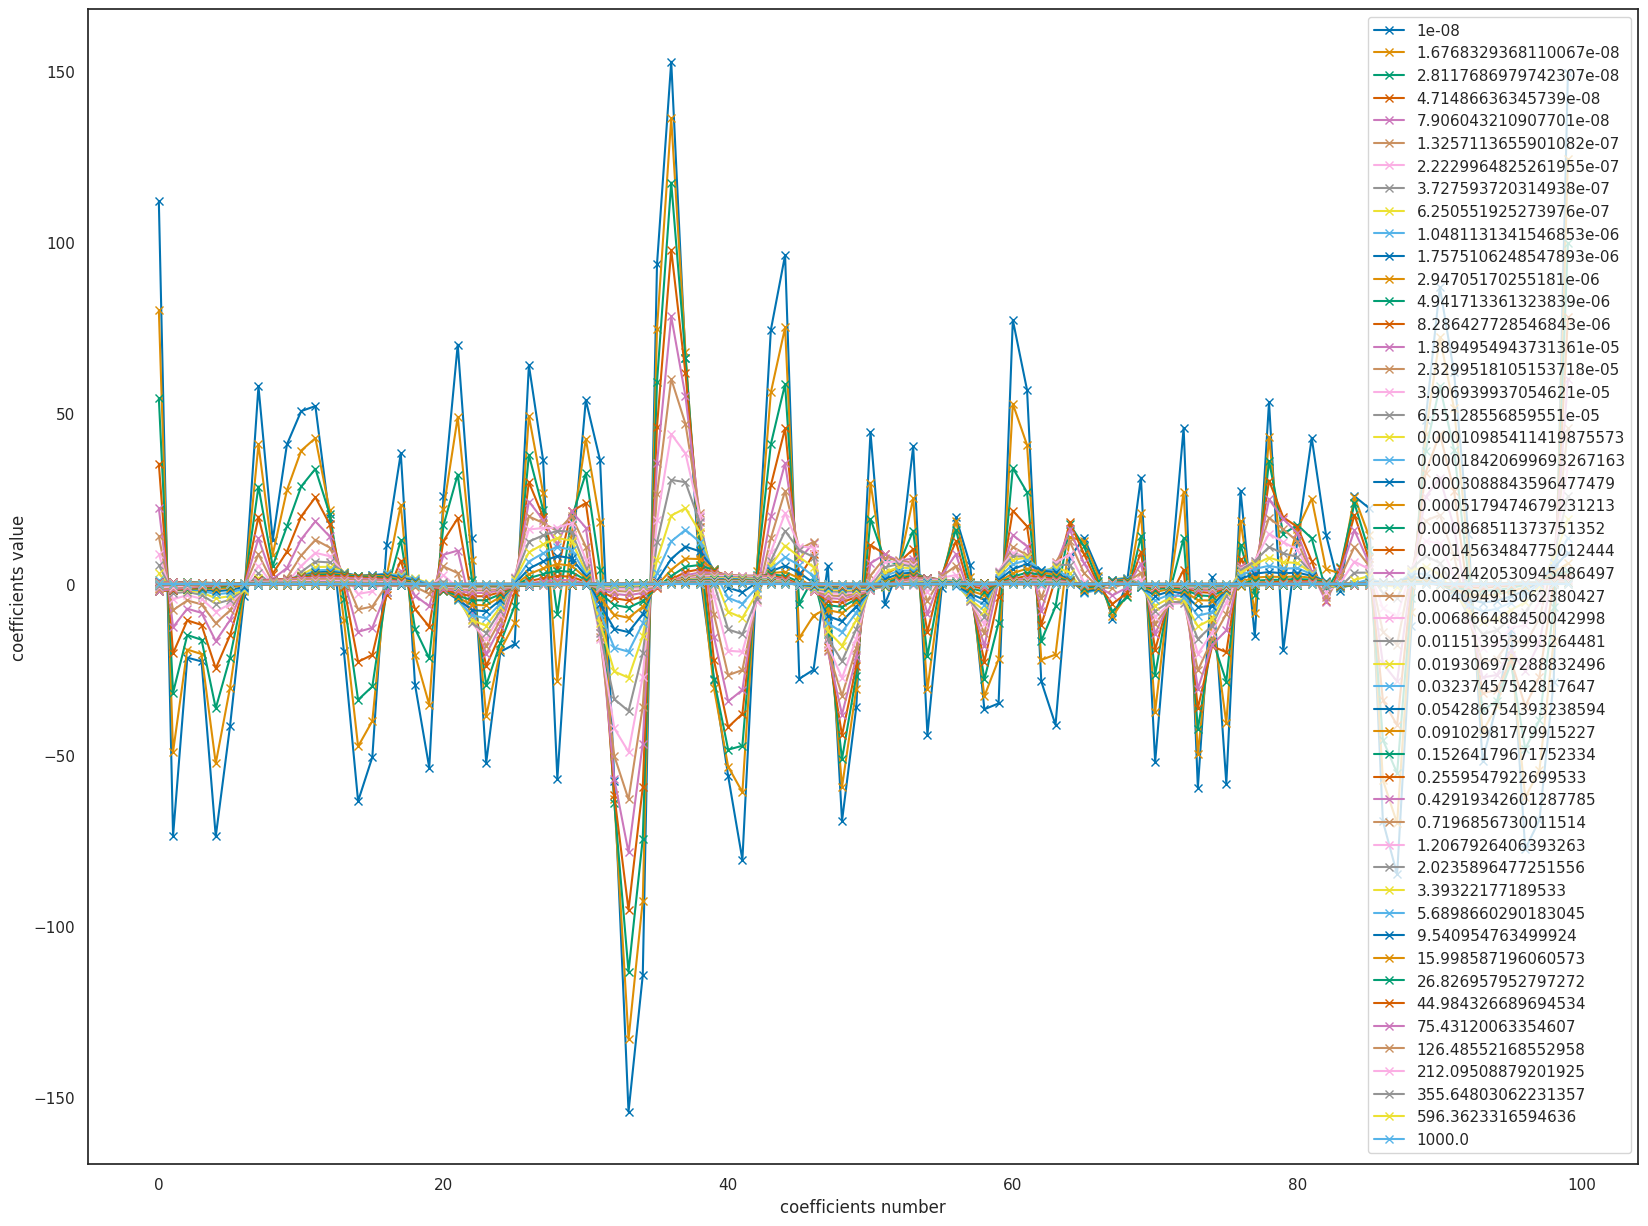

In [46]:
L = [i for i in range(100)]

fig, ax = plt.subplots(figsize=(20,15))

for a in A :
    ax.plot(L, ridge(a, X_train, Y_train)[0], "-x", label=a)

plt.xlabel('coefficients number')  
plt.ylabel('coefficients value')
plt.legend()
plt.show()

As α increases, the values of the coefficients decrease little by little until all are worth 0 

### 5) b. Plot how MSE of both the train and test sets change with α. Signal the minimum with a point.

In [ ]:
from sklearn.metrics import mean_squared_error as mse

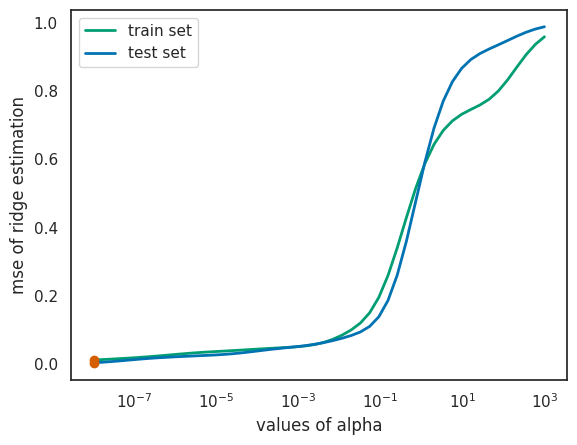

In [47]:
L1 = [mse (Y_train, X_train@ridge(a, X_train, Y_train)) for a in A]
L2 = [mse (Y_test, X_test@ridge(a, X_test, Y_test)) for a in A]

plt.plot(A, L1, 'g', label = 'train set', linewidth = 2)
plt.plot(A[L1.index(min(L1))], min(L1), 'ro')
plt.plot(A, L2, 'b', label = 'test set', linewidth = 2)
plt.plot(A[L2.index(min(L2))], min(L2), 'ro')
plt.xscale('log')
plt.xlabel('values of alpha')  
plt.ylabel('mse of ridge estimation')
plt.legend()
plt.show()

The mean squared error increases with the value of α.

### 5) c. For the best performing value of α (the one with smallest training error) store the R2 results.

In [48]:
df_coef.loc[3] = np.corrcoef(Y_test[0], X_test@ridge(A[0], X_train, Y_train)[0])[0,1]
df_coef

,R2
0,0.972177
1,0.966542
2,0.973532
3,0.984925


We obtain a way better R2 with a ridge estimator.

# Crossvalidation, Lasso and elastic net
## 6) Use the sklearn version of the Lasso. Test it for a penalty parameter α spaced evenly on a log scale 10e-5 to 10e-2.


### 6) a. To avoid having warnings and error you want to decrease the parameter tol or increase max_iter. Elaborate on why these warning arise and on the solution.

In [49]:
from sklearn.linear_model import Lasso
#Lasso(alpha=a, fit_intercept=False, max_iter=1000, tol=0.0001)

In [50]:
A = np.logspace(-4, -1)
results_lasso = []
for a in A :
    results_lasso.append(Lasso(alpha = a, fit_intercept = False, max_iter = 10**6).fit(X_train, Y_train))

Warnings arise when the lasso regression algorithm does not converge. To prevent this, it is therefore possible to increase the number of iterations or to decrease the tolerance, which allows the algorithm to reach a satisfactory state.

### 6) b. Plot the number of coefficients that are different from 0 for each value of α.

In [51]:
L = []
for i in results_lasso : 
    L.append(len(i.coef_[i.coef_!=0]))

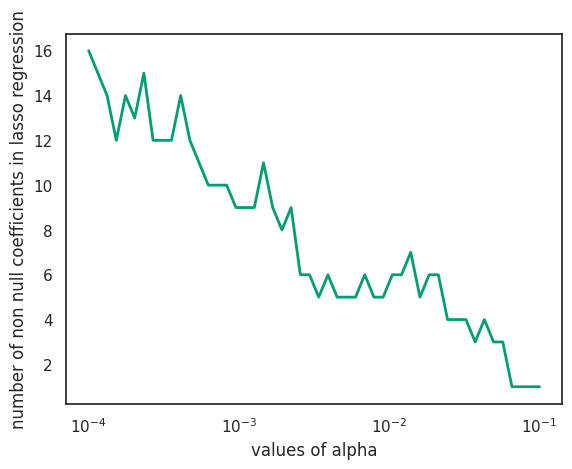

In [52]:
plt.plot(A, L, 'g', linewidth = 2)
plt.xlabel('values of alpha')  
plt.ylabel('number of non null coefficients in lasso regression')
plt.xscale('log')
plt.show()

The number of values equal to 0 globally increases with the value of α.

### 6) c. Plot how MSE of both the train and test sets change with α. Signal the minimum with a point.

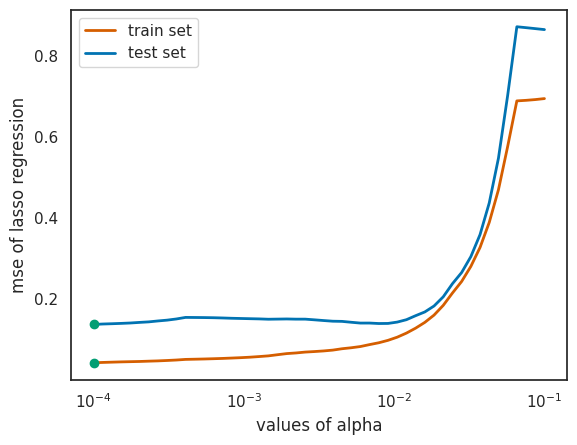

In [54]:
L1 = [mse (Y_train, X_train@i.coef_) for i in results_lasso]
L2 = [mse (Y_test, X_test@i.coef_) for i in results_lasso]

plt.plot(A, L1, '-r', label = 'train set', linewidth = 2)
plt.plot(A[L1.index(min(L1))], min(L1), 'go')
plt.plot(A, L2, 'b', label = 'test set',  linewidth = 2)
plt.plot(A[L2.index(min(L2))], min(L2), 'go')
plt.xscale('log')
plt.xlabel('values of alpha')  
plt.ylabel('mse of lasso regression')
plt.legend()
plt.show()

The mse increases with the value of α.

### 6) d. For the best performing value of α on the test set store the R2 results.

In [58]:
df_coef.loc[4] = np.corrcoef(Y_test[0], X_test@results_lasso[0].coef_)[0,1]
df_coef

,R2
0,0.972177
1,0.966542
2,0.973532
3,0.984925
4,0.968322


This is not the worst correlation coefficient but it is really inferior to the one obtained with ridge.




## 7) Code your own version of the crossvalidation. Preferable, in the same way as sklearn’s version, the length of every pair of folds should differ at most by one. Use the sklearn version of the Elastic net. Validate with a cross-validation that you implement. Test it for a penalty parameter α-ridge spaced evenly on a log scale 10e-10 to 10e3 and α-lasso in [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99].

In [59]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold

In [60]:
A_ridge = np.logspace(-9, 4)
A_lasso = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99]
L_ridge = []
L_lasso = []

In [61]:
rn = range(1,len(df))

kf5 = KFold(n_splits=5, shuffle = True)

def split(train_index, test_index):
    X_train = df.iloc[train_index, :100]
    X_test = df.iloc[test_index, :100]
    Y_train = df.iloc[train_index].loc[:,'fat']
    Y_test = df.iloc[test_index].loc[:,'fat']

    X_train = pd.DataFrame(scaler().fit_transform(np.array(X_train)))
    Y_train = pd.DataFrame(scaler().fit_transform(np.array(Y_train).reshape(-1,1)))
    X_test = pd.DataFrame(scaler().fit_transform(X_test))
    Y_test = pd.DataFrame(scaler().fit_transform(np.array(Y_test).reshape(-1,1)))

    return X_train, Y_train, X_test, Y_test

In [62]:
def test(a, i) : 
  
  scores_mse = []

  for train_index, test_index in kf5.split(rn):
          X_train, Y_train, X_test, Y_test = split(train_index, test_index)
          model = ElasticNet(alpha = a, l1_ratio = i, fit_intercept = False)
          reg = model.fit(X_train, Y_train)  
          Y_pred = model.predict(X_test)
          scores_mse.append(mse(Y_test, Y_pred))
        
  return np.mean(scores_mse)

In [ ]:
liste_mse = []
for a in A_ridge :
    for i in A_lasso :
     liste_mse.append(test(a, i))

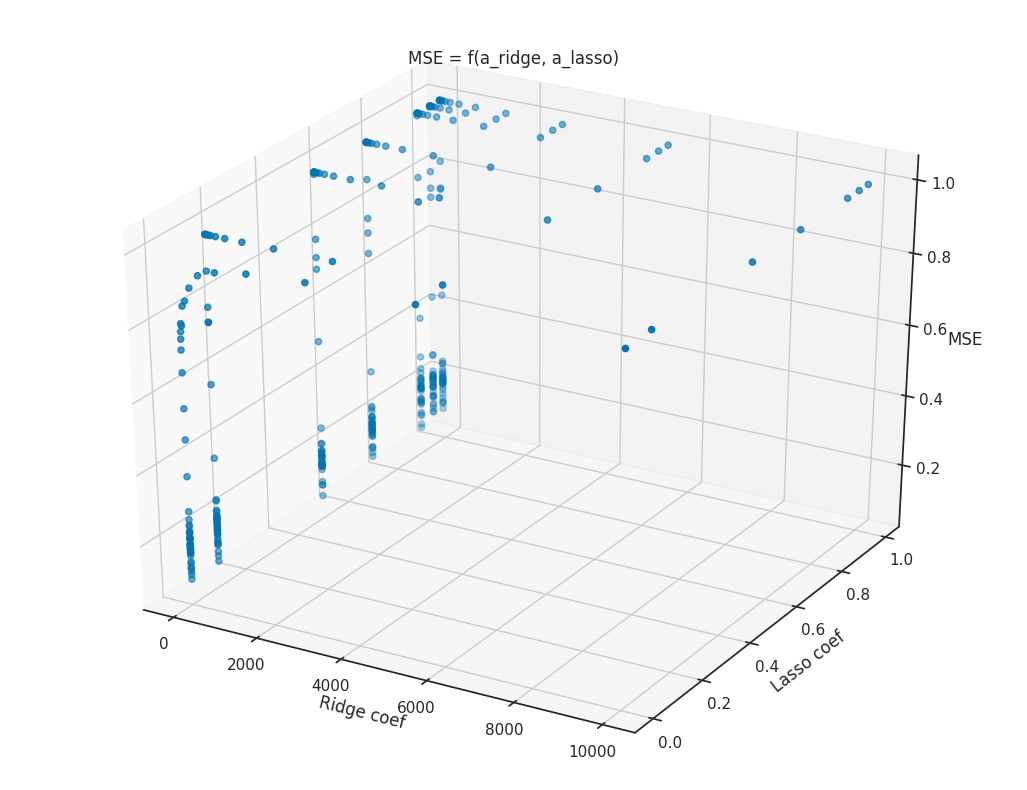

In [64]:
fig = plt.figure(figsize=(13,10))
ax = fig.gca(projection='3d')  

x1 = [A_ridge[j] for j in range(len(A_ridge)) for i in range(len(A_lasso))]
x2 =  A_lasso*len(A_ridge)
#ax.set_xscale('log')
ax.scatter(x1, x2, liste_mse, 'o') 

plt.title("MSE = f(a_ridge, a_lasso)")

ax.set_xlabel('Ridge coef')
ax.set_ylabel('Lasso coef')
ax.set_zlabel('MSE')
plt.show()

# Bootstrap
## 8) For this question, we are going to use only variable 40 of the dataset original (non-centered) X. Plot the dataset and the regression line fitted with the whole sample. Generate 50 bootstrap samples, for each of the samples fit a regression model and plot the 50 estimated regression lines in the same plot (by setting alpha=.4 in the plotting function you can make the lines more transparent for the sake of readability of the plot). Finally, in the same plot, plot the prediction intervals.

In [65]:
from sklearn.utils import resample

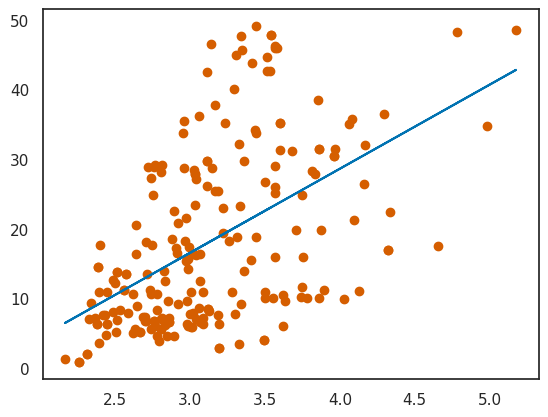

In [66]:
const = np.ones(np.shape(X)[0])
x = X['V41']
x1 = np.column_stack((const, x))
y = Y
model = sm.OLS(y, x1)
results = model.fit()

plt.plot(x, y, 'ro')
plt.plot(x, x*results.params[1]  + results.params[0])
plt.show()

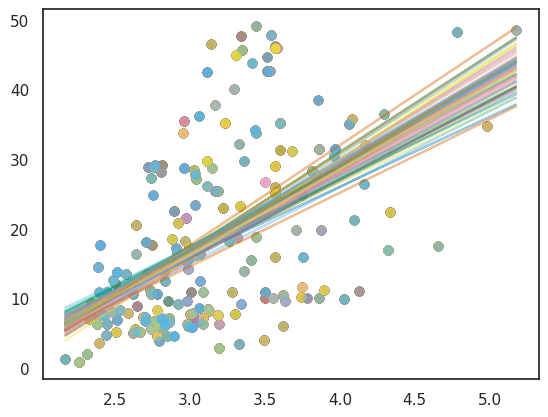

In [67]:
for i in range(50):
    x_sample, y_sample = resample(x, y)
    x1 = np.column_stack((const, x_sample))
    model = sm.OLS(y_sample, x1)
    results = model.fit()
    plt.plot(x, x*results.params[1] + results.params[0], alpha = 0.4)
    plt.scatter(x_sample, y_sample, alpha = 0.4)

plt.show()

# PCA 
## 9) Compute the covariance matrix. Compute the singular value decomposition of the covariance matrix. For consistency int he notation use U,s,V = SVD(X.T@X).

### 9) a. Plot a heatmap of the covariance matrix.

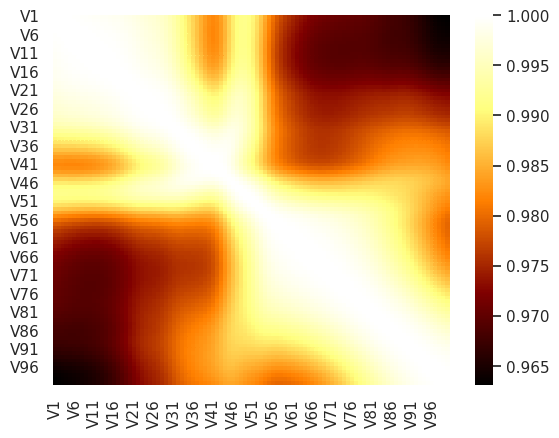

In [68]:
cov_matrix = X.corr()
plt.figure()
htmp = sns.heatmap(cov_matrix, cmap="afmhot")
plt.show()
plt.close()

In [69]:
from numpy.linalg import svd

In [70]:
U, S, V = svd(cov_matrix, full_matrices = False)

### 9) b. In PCA we transform the data to a new coordinate system such that the greatest variance by some scalar projection of the data lies on the first coordinate (called the first principal component, PC1), the second greatest variance in the second PC and so on. The PCs are computed given the above SVD, as XU. Instead of using the whole transformation, XU. ???

In [71]:
 var = (S**2)/(np.sum(S**2))
 var

array([9.99893968e-01, 9.66604667e-05, 8.02022914e-06, 1.34600976e-06,
       4.29098457e-09, 7.08097130e-10, 5.30984480e-11, 1.51975417e-11,
       5.52997408e-13, 2.12059981e-13, 4.00169372e-14, 1.31149538e-14,
       1.24945796e-15, 3.69119708e-16, 8.19521414e-17, 5.73078238e-17,
       3.35441605e-17, 2.43593135e-17, 1.23172168e-17, 4.71508408e-18,
       2.36972728e-18, 1.28151896e-18, 9.77511535e-19, 5.63830599e-19,
       4.81158017e-19, 2.03657319e-19, 1.49906347e-19, 1.22328249e-19,
       9.19351478e-20, 7.73440546e-20, 5.76225879e-20, 4.83786945e-20,
       3.86282236e-20, 3.30366420e-20, 2.66312895e-20, 1.40832549e-20,
       1.20391901e-20, 1.01955906e-20, 6.99120390e-21, 5.80250015e-21,
       4.26598073e-21, 3.73123451e-21, 3.01669151e-21, 2.20796298e-21,
       1.88139676e-21, 1.76824625e-21, 1.24312470e-21, 8.88678257e-22,
       6.56299426e-22, 5.89191295e-22, 4.63484650e-22, 3.91943192e-22,
       2.73105085e-22, 2.26891874e-22, 2.14272356e-22, 1.80412659e-22,
      

In [72]:
PC = X@V[:2].T

### 9) c. Plot the amount of variance explained by the first k components for k in [2; p].

In [73]:
L = []
for k in range(1, 101) : 
    L.append(sum(var[:k])) 
print(np.array(L))

[0.99989397 0.99999063 0.99999865 0.99999999 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


### 9) d. We will use (as an approximation) the first 2 PCs. Plot the projected data using as color the value of y and interpret the plot.

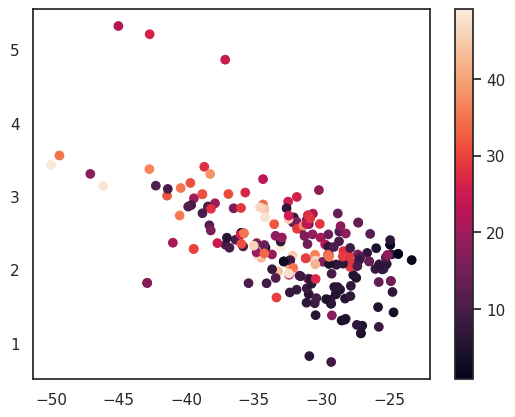

In [74]:
plt.scatter(PC.iloc[:, 0], PC.iloc[:, 1], c = y)
plt.colorbar()
plt.show()

The separation of data is quite satisfactory. It would be more visible with a different scale. 

### 9) e. Run OLS on the projected data using k components for k evenly spaced in [2;p]. Store the best score in the dataFrame.

# Comparison of the models
## 10) Summarize the results of the models and elaborate in their main characteristics.

The information provided by the covariates in the data base is very redundant. A single variable is responsible for more than 99% of the model variance. <p> Moreover, as seen in the covariance matrix, there is a lot of collinearity. </p>
<p> Whatever the regression method, R2 is at least 0.96 which shows that the data explain almost entirely the values ​​of fat. </p>


In [75]:
x_axis = [i for i in range(1, 101)]

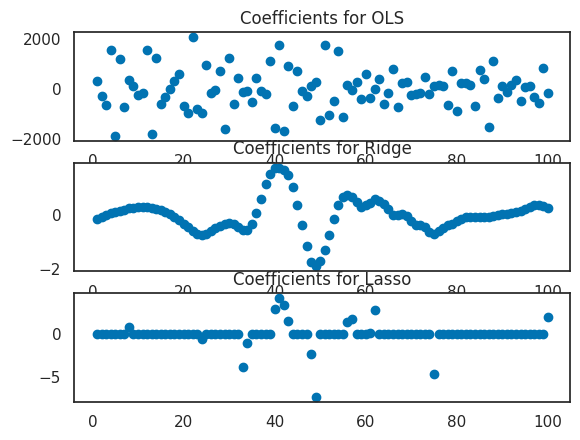

In [88]:
fig, axs = plt.subplots(3, 1)
axs = axs.ravel()

axs[0].scatter(x_axis,results_OLS.params)
#axs[0].set_ylim(-6, 3.5)
axs[0].set_title("Coefficients for OLS")

axs[1].scatter(x_axis, ridge(A[0], X_train, Y_train)[0])
#axs[1].set_ylim(-6, 3.5)
axs[1].set_title("Coefficients for Ridge")

axs[2].scatter(x_axis, results_lasso[0].coef_)
#axs[2].set_ylim(-6, 3.5)
axs[2].set_title("Coefficients for Lasso")

plt.show()